### Importing Libraries and Data

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sklearn.metrics as sm
import seaborn as sns
import re
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [114]:
df = pd.read_csv('../website_classification.csv')
df.head(5)

,website_url,cleaned_website_text,Category
0,https://www.thefulltoss.com/,toss cricket blog english cricket spin irrever...,News
1,https://secondlife.com/,official site second life virtual world virtua...,Social Networking and Messaging
2,https://www.paltalk.com/,video chat paltalk large video chat room commu...,Social Networking and Messaging
3,https://secure.imvu.com/welcome/ftux/,imvu 3d avatar social app virtual world virtua...,Social Networking and Messaging
4,https://enterchatroom.com/,enter chatroom free online chat room free chat...,Social Networking and Messaging


In [115]:
df.info() #checking if there is any Nan or null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   website_url           963 non-null    object
 1   cleaned_website_text  963 non-null    object
 2   Category              963 non-null    object
dtypes: object(3)
memory usage: 22.7+ KB


In [116]:
df["Category"].value_counts()

Computers and Technology           302
Social Networking and Messaging    114
Business/Corporate                 106
E-Commerce                         101
News                                93
Law and Government                  83
Narcotics                           74
Adult                               43
Financial Crime                     31
Forums                              16
Name: Category, dtype: int64

### Visualising distribution of website categories

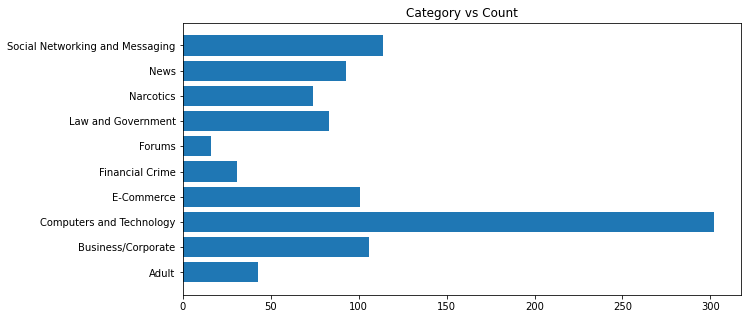

In [117]:
#visualising the count of each category
plt.figure(figsize=(10,5))
plt.title("Category vs Count")
site_category_count = pd.DataFrame(df.groupby(df['Category']).size(),columns=['Count'])
plt.barh(width=site_category_count['Count'],y=site_category_count.index)
plt.show()

In [118]:
site_category_count.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, Adult to Social Networking and Messaging
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   10 non-null     int64
dtypes: int64(1)
memory usage: 160.0+ bytes


In [119]:
print("Different categories of websites: ",len(site_category_count["Count"]))

Different categories of websites:  10


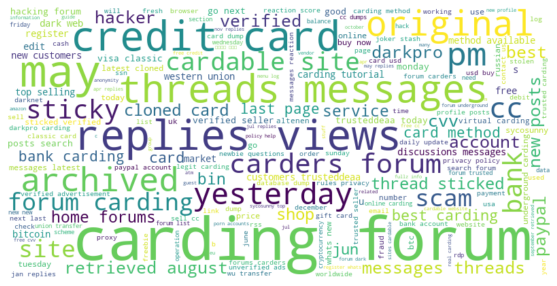

In [120]:
from wordcloud import WordCloud

category_name = "Financial Crime"
category_data = df[df["Category"]==category_name]['cleaned_website_text']
category_text = ' '.join(category_data)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(category_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Data Cleaning & Engineering

##### NLP pipeline
##### 1. Text processing
######    - Cleaning
######    - Normalization (changing to lowercase and removing punctuation)
######    - Word Tokenisation
######    - Remove stop words
######    - Remove Non-alpha text
######    - Word Stemming and Lemmatization

##### 2. Feature Engineering
######    - Label Encoding for Categories
######    - Bag of Words (CountVectorizer)
######    - TF-IDF (Bag of Words + Tf-IDF = TfidfVectorizer)
######    - Word Embeddings (word2vec/glove)

##### 3. Feature Selection

Normalizing text: convert to lowercase and remove punctuation

In [121]:
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: x.lower())
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: re.sub(r'[^\w\s]','',x))
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: re.sub(r'\d+','',x))
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: re.sub(r'\s+',' ',x))

In [122]:
df.head()

,website_url,cleaned_website_text,Category
0,https://www.thefulltoss.com/,toss cricket blog english cricket spin irrever...,News
1,https://secondlife.com/,official site second life virtual world virtua...,Social Networking and Messaging
2,https://www.paltalk.com/,video chat paltalk large video chat room commu...,Social Networking and Messaging
3,https://secure.imvu.com/welcome/ftux/,imvu d avatar social app virtual world virtual...,Social Networking and Messaging
4,https://enterchatroom.com/,enter chatroom free online chat room free chat...,Social Networking and Messaging


Tokenising: Split sentence into list of words

In [123]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User01\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Removing Stopwords

In [124]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: [word for word in x if word not in stop_words])
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: [word for word in x if len(word)>2])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Word Stemming and Lemmatization

In [125]:
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
lem = WordNetLemmatizer()

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'
    
#Define function to lemmatize each word with its POS tag
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    pos_tagged_text = [(word, pos_tagger(pos_tag)) for word, pos_tag in pos_tagged_text]
    return [lem.lemmatize(word, pos_tag) for word, pos_tag in pos_tagged_text]

df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: lemmatize_words(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User01\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [126]:
#joining tokenized words
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: ' '.join(x))

Feature extraction: Label Encoding

In [127]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])

In [128]:
df.head()

,website_url,cleaned_website_text,Category
0,https://www.thefulltoss.com/,toss cricket blog english cricket spin irrever...,8
1,https://secondlife.com/,official site second life virtual world virtua...,9
2,https://www.paltalk.com/,video chat paltalk large video chat room commu...,9
3,https://secure.imvu.com/welcome/ftux/,imvu avatar social app virtual world virtual r...,9
4,https://enterchatroom.com/,enter chatroom free online chat room free chat...,9


In [129]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df['cleaned_website_text'],df['Category'],test_size=0.2,random_state=42)

In [130]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((770,), (193,), (770,), (193,))

Feature extraction: Tf-idf vectorizer

In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_id_vectorizer = TfidfVectorizer(analyzer='word',smooth_idf=True,max_features=5000)
tf_id_train = tf_id_vectorizer.fit_transform(X_train)
tf_id_test = tf_id_vectorizer.transform(X_test)

In [ ]:
#Adding feature selection using RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
rfe = RFE(lg, n_features_to_select=10)
rfe.fit(tf_id_train.toarray(), y_train)
selected_features = tf_id_vectorizer.get_feature_names()[rfe.support_]


#new vectorizer
tf_id_vectorizer = TfidfVectorizer(analyzer='word', smooth_idf=True, vocabulary=selected_features)

Model training

In [133]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have your training data (X_train) and corresponding labels (y_train)

# Define the models and their respective hyperparameters to try during grid search
models = {
    'MNB': {
        'model': MultinomialNB(),
        'params': {
            'mnb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'svm__C': [1, 10],
            'svm__kernel': ['linear', 'rbf']
        }
    },
}

# Perform grid search and cross-validation for each model
for model_name, model_data in models.items():
    print("Evaluating:", model_name)
    
    # Create a pipeline with a TF-IDF vectorizer and the current model
    pipeline = Pipeline([
        ("tf_id_vectorizer", TfidfVectorizer(analyzer='word', smooth_idf=True, vocabulary=selected_features)),
        ("feature_selection", SelectKBest(score_func=chi2)),
        (model_name.lower(), model_data['model'])
    ])
    
    # Define the hyperparameters for the current model
    parameters = {
        'feature_selection__k':[1000, 2000, 3000, 4000, 5000],
        **model_data['params']
    }
    
    # Perform grid search with 5-fold cross-validation
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best model and its corresponding hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Make predictions on the test set
    y_pred = best_model.predict(X_test)
    
    # Calculate and print evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted',zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted',zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted',zero_division=0)
    
    print("Best parameters:", best_params)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    print("----------------------------------")

Evaluating: MNB
Best parameters: {'feature_selection__k': 5000, 'mnb__alpha': 0.1}
Accuracy: 0.8963730569948186
Precision: 0.883795776336891
Recall: 0.8963730569948186
F1 score: 0.8813742385088172
----------------------------------
Evaluating: SVM
Best parameters: {'feature_selection__k': 5000, 'svm__C': 10, 'svm__kernel': 'linear'}
Accuracy: 0.917098445595855
Precision: 0.9234829829770397
Recall: 0.917098445595855
F1 score: 0.9140716248335911
----------------------------------


In [134]:
from sklearn.feature_selection import chi2
chi2_selector = SelectKBest(score_func=chi2, k=best_params['feature_selection__k'])

X_train_selected = chi2_selector.fit_transform(tf_id_train, y_train)
X_test_selected = chi2_selector.transform(tf_id_test)

In [135]:
model = SVC(C=10,kernel='linear')
model.fit(X_train_selected,y_train)

SVC(C=10, kernel='linear')

In [136]:
import sklearn.metrics as sm

y_pred = model.predict(X_test_selected)
print(f'The accuracy of train model is {sm.accuracy_score(y_train,model.predict(X_train_selected))}')
print(f'The accuracy of test model is {sm.accuracy_score(y_test,y_pred)}')

The accuracy of train model is 0.9987012987012988
The accuracy of test model is 0.917098445595855


In [137]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import os


class ScrapTool:   
    def visit_url(self,website_url):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        #Set up Selenium webdriver
        PATH = 'C:/Users/shrey/Downloads/chromedriver_win32 (1)/chromedriver.exe'

        # Set the Chrome webdriver options
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        # Initialize the Chrome webdriver and pass the Chrome options
        service = Service(PATH)
        driver = webdriver.Chrome(service = service, options = chrome_options)

        #Load website
        driver.get(website_url)
        
        # Check if the cookie consent button is present
        cookie_button = None
        try:
            cookie_button = WebDriverWait(driver, 15).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "cookie-consent-button")))
        except:
            pass

        # Handle cookies if the button is present
        if cookie_button:
            cookie_button.click()

        # Extract HTML content
        html_content = driver.page_source
        driver.quit()

        soup = BeautifulSoup(html_content,'lxml')
        result = {
            "website_url": website_url,
            "website_name": self.get_website_name(website_url),
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+self.get_html_heading_tags(soup)+
                                    self.get_text_content(soup)
        }
        
        #Convert to Series object and return
        return pd.Series(result)
    
    def get_website_name(self,website_url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(website_url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(text=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)

In [138]:
#cleaning text and preprocessing
def cleaning_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'\d+','',text)   
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    text = [word for word in text if len(word)>2]
    text = lemmatize_words(text)
    text = ' '.join(text)
    vector = tf_id_vectorizer.transform([text])
    vector = chi2_selector.transform(vector)
    vector = vector.toarray()
    return vector

In [139]:
def website_prediction(website,model):
    scrapTool = ScrapTool()
    try:
        web = dict(scrapTool.visit_url(website))
        text = cleaning_text(web['website_text'])
        prediction = model.predict(text)
        print(f'The website is under the category of {le.inverse_transform(prediction)[0]}')
    except:
        print("Connection Timeout")

In [140]:
import pickle

filename = 'RootModel.sav'
pickle.dump(model, open(filename, 'wb'))

#loading the model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_selected, y_test)
print(result)

0.917098445595855


              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.88      0.95      0.91        22
           2       1.00      0.86      0.92        70
           3       0.90      0.96      0.93        27
           4       0.57      1.00      0.73         4
           5       0.60      1.00      0.75         3
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00        12
           8       1.00      0.88      0.94        17
           9       0.76      0.87      0.81        15

    accuracy                           0.92       193
   macro avg       0.86      0.95      0.89       193
weighted avg       0.93      0.92      0.92       193



<AxesSubplot:>

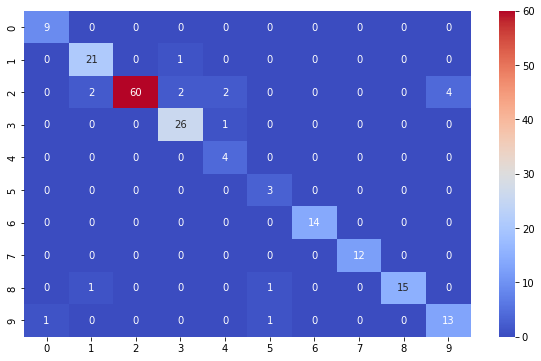

In [141]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

plt.figure(figsize=(10,6))
predictions = model.predict(X_test_selected)
print(classification_report(predictions,y_test))
sns.heatmap(confusion_matrix(predictions,y_test),cmap='coolwarm',annot=True)

In [442]:
pd.set_option('display.max_rows', None)
predictions = model.predict(X_test_selected)
results = pd.DataFrame({'Cleaned Text':X_test,'Actual':y_test,'Predicted':predictions})
results[(results['Actual']==5) & (results['Actual']!=results['Predicted'])]

,Cleaned Text,Actual,Predicted
830,bitcoin mixer expert introduce top tumbler pro...,2,1
605,ethereum development dappsrethdev ethereumrela...,2,9


In [413]:
df.iloc[346]

website_url                                 http://www.cordlessworkz.com/
cleaned_website_text    cordless phone jitterbug phone hear impaired p...
Category                                                                3
Name: 346, dtype: object